In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Classroom/AI/FinalProject

/content/drive/MyDrive/Classroom/AI/FinalProject


In [3]:
!pip install opencv-python mediapipe pandas numpy tensorflow

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# --- 1. Data Loading & Preprocessing ---
filename = '/content/drive/MyDrive/Classroom/AI/FinalProject/dataset/hand_keypoints.csv'
df = pd.read_csv(filename)

# Separating features (coordinates) and target (labels)
# Assuming 'label' is the first column. If it's the last, change logic accordingly.
X = df.iloc[:, 2:].values
y = df.iloc[:, 0].values

# Force X to be a FLOAT32 data type (Decimal Value)
try:
    X = X.astype('float32')
    print("Data type conversion success")
except ValueError:
    print("Error: There is non-number in coordinate column, check the CSV file.")

# Encode labels (A, B, C -> 0, 1, 2)
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Save label mapping for Android app usage
classes = encoder.classes_
np.savetxt('labels.txt', classes, fmt='%s')
print(f"Label ditemukan ({len(classes)}): {classes}")

# Split data (80% Train, 20% Validation)
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print("Data X shape:", X_train.shape)
print("Data X type:", X_train.dtype)

# --- 2. Model Architecture ---
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),

    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(len(classes), activation='softmax')
])

# --- 3. Compilation ---
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# --- 4. Training ---
print("\nStarting training...")
history = model.fit(X_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_test, y_test))

# --- 5. Evaluation ---
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nFinal Validation Accuracy: {accuracy * 100:.2f}%")

# --- 6. Save Model ---
model_name = 'hand_sign_model.h5'
model.save(model_name)
print(f"Model saved as {model_name}")

Data type conversion success
Label ditemukan (27): ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' 'space']
Data X shape: (10760, 42)
Data X type: float32

Starting training...
Epoch 1/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.0967 - loss: 3.2011 - val_accuracy: 0.4587 - val_loss: 2.2141
Epoch 2/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4421 - loss: 1.9599 - val_accuracy: 0.8528 - val_loss: 0.9352
Epoch 3/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6754 - loss: 1.0558 - val_accuracy: 0.8658 - val_loss: 0.5914
Epoch 4/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7563 - loss: 0.7355 - val_accuracy: 0.9357 - val_loss: 0.3951
Epoch 5/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8211 - loss: 0.5522 - val_accuracy: 0.9294 - val_loss: 0.3104
Epoch 6/100
337/337 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8462 - loss: 0.4486 - val_accuracy: 0.9520 - val_los


Final Validation Accuracy: 99.93%
Model saved as hand_sign_model.h5


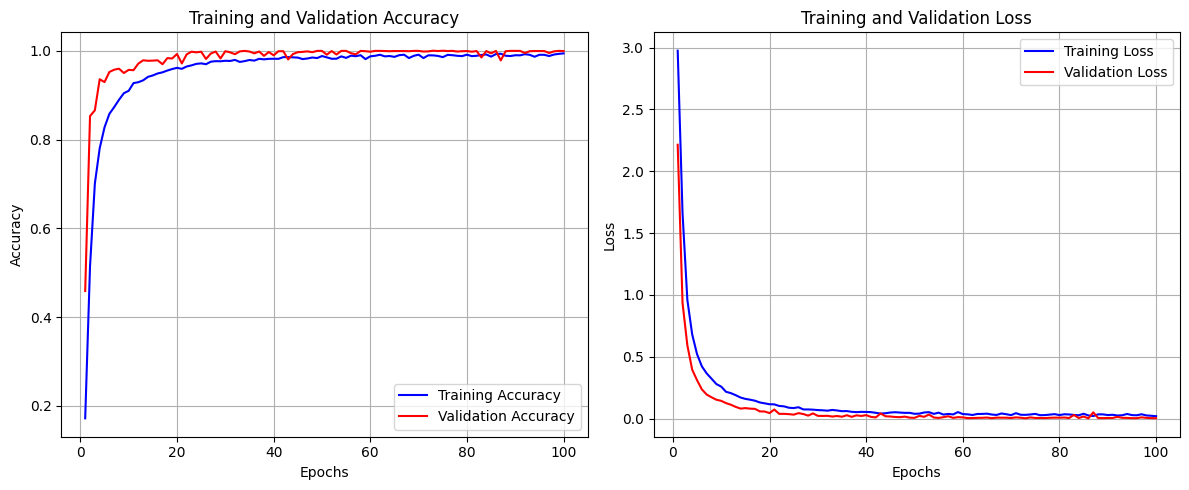

In [6]:
import matplotlib.pyplot as plt

# Take the training data results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# --- 1st PLOT: ACCURACY ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# --- 2nd PLOT: LOSS ---
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf

# --- 1. Load the Previously Trained Model ---
model_name = '/content/drive/MyDrive/Classroom/AI/FinalProject/hand_sign_model.h5'
model = tf.keras.models.load_model(model_name)

# --- 2. Setup Converter ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# [Optional] Optimization: Reduce file size (Quantization)
# This will make the model faster on mobile devices
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# --- 3. Perform Conversion ---
print("Converting model to TFLite...")
tflite_model = converter.convert()

# --- 4. Save the .tflite File ---
tflite_filename = 'hand_sign_model.tflite'
with open(tflite_filename, 'wb') as f:
    f.write(tflite_model)

print(f"\nSUCCESS! Model saved as: {tflite_filename}")

Converting model to TFLite...
Saved artifact at '/tmp/tmphxrnhsfw'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 27), dtype=tf.float32, name=None)
Captures:
  138582043033040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138581419874768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138581419882832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138581419884368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138581419883024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138581419878032: TensorSpec(shape=(), dtype=tf.resource, name=None)

SUCCESS! Model saved as: hand_sign_model.tflite


In [8]:
import numpy as np

# --- 1. Get 10 random samples from the test data (X_test) ---
indices = np.random.choice(len(X_test), 10)
X_samples = X_test[indices]
y_true_samples = y_test[indices]

# --- 2. Make Predictions ---
predictions = model.predict(X_samples)

# --- 3. Display Results ---
print("\n=== PREDICTION TEST RESULTS ===")
for i in range(10):
    # Get the index with the highest probability
    pred_idx = np.argmax(predictions[i])
    confidence = predictions[i][pred_idx]

    # Decode the number back to a letter (0 -> 'A')
    true_label = encoder.inverse_transform([y_true_samples[i]])[0]
    pred_label = encoder.inverse_transform([pred_idx])[0]

    status = "✅ CORRECT" if true_label == pred_label else "❌ INCORRECT"

    print(f"Sample #{i+1}: True [{true_label}] --> Predicted [{pred_label}] (Confidence: {confidence*100:.1f}%) {status}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step

=== PREDICTION TEST RESULTS ===
Sample #1: True [H] --> Predicted [H] (Confidence: 100.0%) ✅ CORRECT
Sample #2: True [D] --> Predicted [D] (Confidence: 100.0%) ✅ CORRECT
Sample #3: True [G] --> Predicted [G] (Confidence: 100.0%) ✅ CORRECT
Sample #4: True [L] --> Predicted [L] (Confidence: 100.0%) ✅ CORRECT
Sample #5: True [R] --> Predicted [R] (Confidence: 99.5%) ✅ CORRECT
Sample #6: True [V] --> Predicted [V] (Confidence: 100.0%) ✅ CORRECT
Sample #7: True [U] --> Predicted [U] (Confidence: 100.0%) ✅ CORRECT
Sample #8: True [L] --> Predicted [L] (Confidence: 100.0%) ✅ CORRECT
Sample #9: True [T] --> Predicted [T] (Confidence: 100.0%) ✅ CORRECT
Sample #10: True [R] --> Predicted [R] (Confidence: 100.0%) ✅ CORRECT


85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


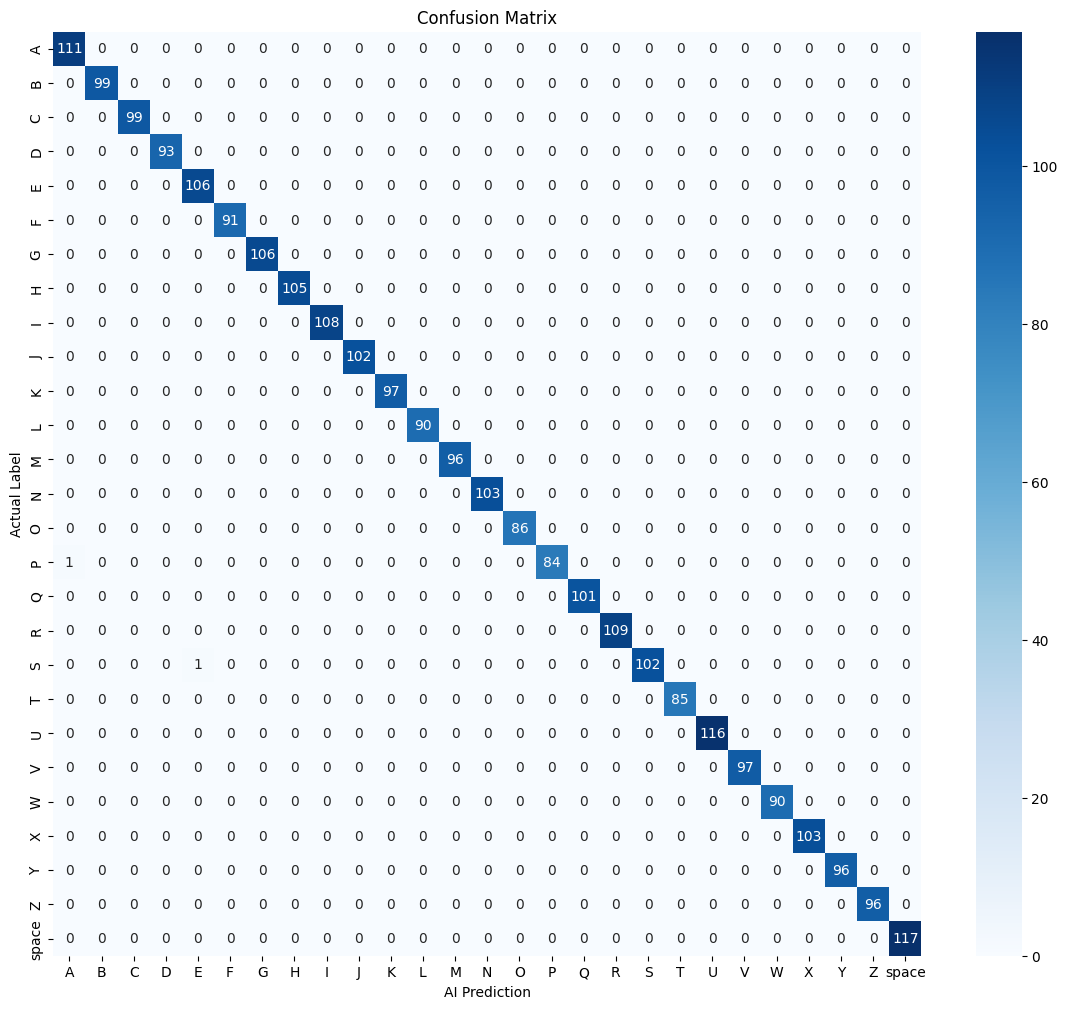

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Predict ALL test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Calculate the Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)

# 3. Plot the Confusion Matrix
plt.figure(figsize=(14, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('AI Prediction')
plt.ylabel('Actual Label')
plt.show()